# eTraGo: Minimal Example

The following notebook shows you how you can run the selected, basic functions of eTraGo in a minimal system.
First, the execution is shown step by step, including information on different functionalities.
Afterwards, information on more automated eTraGo runs is provided.

More information on the described functions, as well as a description of all options, is provided in the __[eTraGo Documentation on read the docs](http://etrago.readthedocs.io/)__

## Import required general and eTraGo specific python packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

from etrago import Etrago

## Initialize object and set parameters

In [2]:
etrago = Etrago(args={}, json_path="args_minimal_example.json")

## View and adjust parameters

All parameters of an eTraGo calculation are stored in etrago.args. 
They can be defined via a json-file or as a dictionary. Documentation on all parameters is provided in the read the docs. 
This example shows how to show and adjust selected key settings: 

In [3]:
# Scenario name
etrago.args["scn_name"]

'eGon2035'

### Snapshots considered in calculation
For a small example, a limited number of snapshots is selected. For larger, annual calculations eTraGo needs more RAM then a normal laptop provides.
The snapshots are defined as the nth number in a year, so it can be between 1 and 8760.
In this example, the first day of the year is selected:

In [4]:
print(etrago.args["start_snapshot"])
print(etrago.args["end_snapshot"])

1
24


## Import data model from the database

In [5]:
etrago.build_network_from_db()
etrago.adjust_network()

INFO:etrago.tools.io:Importing Buses from database
INFO:etrago.tools.io:Importing Lines from database
INFO:etrago.tools.io:Importing Transformers from database
INFO:etrago.tools.io:Importing Links from database
INFO:etrago.tools.io:Importing Loads from database
INFO:etrago.tools.io:Importing Generators from database
INFO:etrago.tools.io:Importing Storages from database
INFO:etrago.tools.io:Importing Stores from database
INFO:etrago.network:Imported network from db
INFO:etrago.tools.utilities:
            There are 7 lines without a resistance (r) in the data model.
            The resistance of these lines will be automatically set to 0.0001.
            
INFO:etrago.tools.utilities:There are 518 trafos without a resistance (r) in the data model.
            The resistance of these trafos will be automatically set to 0.0001.
            
                The database query failed for
                'scenario.egon_scenario_parameters'.
                Fallback values are being used. Err

In [6]:
etrago.network.links.marginal_cost_quadratic = 0.
etrago.network.generators.marginal_cost_quadratic = 0.

## Complexity Reduction
The data model is characterized by a high spatial (about 8,000 electrical and 600 gas nodes) and temporal resolution (8,760 timesteps). To reduce the complexity of the resulting optimization problem, several methods can be applied.
In this example, we focus on the spatial complexity reduction.

This is how the network looks like in the original resolution:

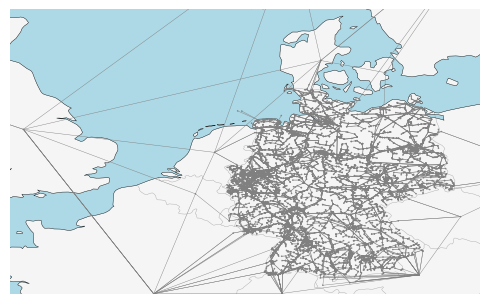

In [7]:
etrago.plot_grid("grey")

In the following, spatial complexity methods are applied. In this minimal example, the electrical network is clustered to 30 nodes.

_Please note that this step can take a few minutes._

In [8]:
# spatial clustering
etrago.spatial_clustering()
etrago.spatial_clustering_gas()  

INFO:etrago.cluster.electrical:

                ----------------------- WARNING ---------------------------
                THE FOLLOWING BUSES HAVE NOT COUNTRY DATA:
                ['13824', '12770', '13665', '13478'].
                THEY WILL BE ASSIGNED TO GERMANY, BUT IT IS POTENTIALLY A
                SIGN OF A PROBLEM IN THE DATASET.
                ----------------------- WARNING ---------------------------

                
INFO:etrago.cluster.electrical:Start k-medoids Dijkstra Clustering
INFO:etrago.cluster.electrical:Network clustered to 30 buses with kmedoids-dijkstra
INFO:etrago.cluster.gas:Start kmedoids-dijkstra clustering GAS
       '48879', '48880',
       ...
       '49480', '49481', '49482', '49483', '49484', '49485', '49486', '49487',
       '49488', '49489'],
      dtype='object', name='Bus', length=619)
       '48763', '48785', '48810'],
      dtype='object', name='Bus')
Index(['8'], dtype='object', name='Line')
INFO:etrago.cluster.gas:CH4 Network clustered to

Afterwards, the electrical grid looks like this:

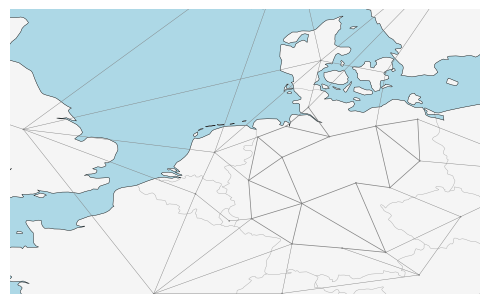

In [9]:
etrago.plot_grid("grey")

## Optimization

eTraGo includes different methods to optimize the German energy system, including the eHV/HV grid.
In this example, an integrated LOPF is selected. This optimizes the dispatch of generation and flexibility options as well as grid and storage expansion in one integrated optimization step.

_Please note that the solver glpk needs to be installed._

In [12]:
etrago.network.links.marginal_cost_quadratic = 0.
etrago.network.generators.marginal_cost_quadratic = 0.
etrago.optimize()

Index(['8'], dtype='object', name='Line')
Index(['8'], dtype='object', name='Line')
INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|████████████████| 13/13 [00:00<00:00, 351.98it/s]
INFO:linopy.io: Writing time: 0.52s


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-o0_xvyo4.lp --output /tmp/linopy-solve-87tbyt20.sol
Reading problem data from '/tmp/linopy-problem-o0_xvyo4.lp'...
55828 rows, 26373 columns, 105356 non-zeros
308629 lines were read
GLPK Simplex Optimizer 5.0
55828 rows, 26373 columns, 105356 non-zeros
Preprocessing...
16920 rows, 23462 columns, 63254 non-zeros
Scaling...
 A: min|aij| =  1.957e-03  max|aij| =  2.552e+02  ratio =  1.304e+05
GM: min|aij| =  1.407e-01  max|aij| =  7.106e+00  ratio =  5.049e+01
EQ: min|aij| =  1.986e-02  max|aij| =  1.000e+00  ratio =  5.034e+01
Constructing initial basis...
Size of triangular part is 16902
      0: obj =   6.299206838e+08 inf =   3.014e+07 (1639)
   8188: obj =   1.081403425e+09 inf =   9.633e-12 (0) 41
* 14520: obj =   6.101747483e+08 inf =   1.553e-12 (7418) 47
* 20713: obj =   5.186221356e+08 inf =   6.309e-12 (6729) 47
* 27429: obj =   4.844220623e+08 inf =   1.313e-08 (3424) 49
* 3375

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26373 primals, 55828 duals
Objective: 4.82e+08
Solver model: not available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-ext-s-lower, Line-ext-s-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance, Store-energy_balance were not as

Time for LOPF [min]: 0.5


## Result analysis

eTraGo includes different functions to analyze the results.

_Please note that the results of the minimal example are not representative, they are just shown to explain the general usage._

In the following, a map of grid and storage expansion is visualized:

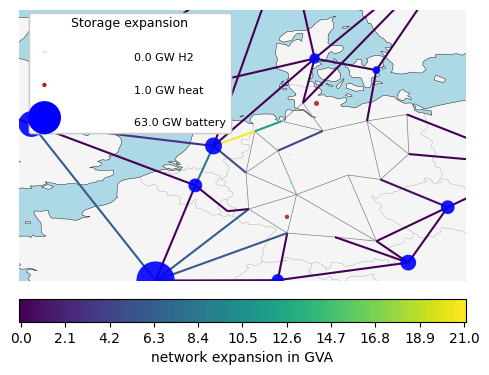

In [13]:
etrago.plot_grid(
    line_colors="expansion_abs",
    bus_colors = "storage_expansion", bus_sizes= 0.000001,
    scaling_store_expansion={"H2": 10,
                            "heat": 10,
                            "battery": 10})

eTraGo also includes functions to calculate general results as tables, such as system costs and total grid expansion:

In [14]:
etrago.calc_results()
etrago.results

,unit,value
annual system costs,EUR/a,483230299.4341
annual investment costs,EUR/a,5814998.289172
annual marginal costs,EUR/a,477415301.144928
annual electrical grid investment costs,EUR/a,2382995.099688
annual ac grid investment costs,EUR/a,171847.122205
annual dc grid investment costs,EUR/a,2211147.977483
annual links investment costs,EUR/a,449803.584414
annual storage+store investment costs,EUR/a,2982199.60507
annual electrical storage investment costs,EUR/a,2980904.071018
annual store investment costs,EUR/a,1295.534051


## Run eTraGo in one function

All eTraGo functions are wrapped in one function. To run the same calculation as shown above, you can also just run these lines:

In [15]:
# from etrago.appl import run_etrago
# run_etrago(args={}, json_path="args_minimal_example.json")